## Algoritmo genético

In [3192]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from sympy import symbols, sympify, lambdify
import time
import copy


In [3193]:
doc2 = open("C:/Users/antoc/Downloads/PortableGit/practica2024/hub_data.txt")
lineas2 = doc2.readlines()

H_0= 70

# Divide cada línea en columnas usando espacio como separador
datos_separados2 = [linea.strip().split(' ') for linea in lineas2]

datos= []
for fila in datos_separados2:
    datos.append(fila)

z = []
for i in range(len(datos)):
      a = float(datos[i][0])
      z.append(a)
z =np.array(z)

H = []
for i in range(len(datos)):
   if datos[i][1] == '':
      a = float(datos[i][2])
      H.append(a)
   else:
      a = float(datos[i][1])
      H.append(a)
H = np.array(H)

desv = []
for i in range(len(datos)):
    a = float(datos[i][2])
    desv.append(a)


Se minimiza $$\chi^2 = \sum_{i=1}^{N} (\dfrac{y_i - f(x_i)}{\sigma_{i}})^2$$ para obtener la función $f(x)$ que mejor se ajuste a los datos.


In [3194]:
def polix(x):
    return x**x
def poli1(x):
    return (x+1) 
def poli2(x):
    return x**2
def poli3(x):
    return x**3
# Crear lista con coeficientes
coeficientes = [random.random() for i in range(5)]
# Crear lista de funciones
funciones_c = [lambda x, i=i: coeficientes[i] for i in range(5)]


grammar = [polix, poli1, poli2, poli3] + funciones_c
operaciones = ['+', '-', '*', '/']



#A partir de las funciones ingresadas inicialmente, calcula el chi_2
def chi_2_valores(f):
    return np.square((H - f(z))/desv)

def chi_2_f(f):
    chi_2_val = np.zeros_like(f)
    chi_2 = np.zeros_like(f)
    for i in range(len(f)):
        chi_2_val[i] = chi_2_valores(f[i])
        for j in range(len(chi_2_val)):
            chi_2[j] = np.sum(chi_2_val[j])
    
    return chi_2

print(chi_2_f(grammar))
chi_inic = chi_2_f(grammar)

[4253.462135836499 4237.5874276237755 4300.926784511239 4239.109972002022
 4324.795459629309 4362.700602669677 4373.6384113163695 4347.961161637781
 4312.863351908091]


### Combinar la función inicial
Se combinan las funciones iniciales con operaciones entre ellas hasta que sean 1000 funciones iniciales.

In [3195]:
def juntar_elementos_inicial(funciones, operaciones, longitud_final=50):
    final = []
    while len(final) < longitud_final * 3:
        random_funcion1 = random.choice(funciones)
        random_funcion2 = random.choice(funciones)
        random_operador = random.choice(operaciones)

        final.append(random_funcion1)
        final.append(random_operador)
        final.append(random_funcion2)

    # Crear una lista de sublistas para representar las filas
    resultado_final_inicial = [final[i:i+3] for i in range(0, len(final), 3)]

    return resultado_final_inicial

resultado_final_inicial = juntar_elementos_inicial(grammar, operaciones)
#for fila in resultado_final_inicial:
#    print(fila)


### Convertir la lista a función
Se definen funciones para para convertir una lista de funciones y strings (operaciones) en una función.

In [3196]:

#x deben estar entre paréntesis para no confundir con otros x en el string
def a_string(funcion):
    if funcion == polix:
        return '(x)**(x)'
    elif funcion == poli1:
        return '((x)+1)'
    elif funcion == poli2:
        return '(x)**2'
    elif funcion == poli3:
        return '(x)**3'
    for i in range(len(funciones_c)):
        if funcion == funciones_c[i]:
            return str(coeficientes[i])
    else:
        return str(funcion)

x = symbols('x')
def pasar_a_funcion(expresion):
    a_sympy = sympify(expresion)
    a_python = lambdify(x, a_sympy, 'numpy')
    return a_python

#print(pasar_a_funcion('exp(x**2)'))(2)
def composicion(lista):
    modi_int = a_string(lista[-1])
    #print(modi_int)
    for i in range(2,len(lista)+1):
        modi_ext = a_string(lista[-i])
        modi_int = modi_ext.replace('(x)', '('+ modi_int +')' )
    return modi_int


def convertir_lista_a_str(lista):
    string=''
    for i in range(len(lista)):
        if callable(lista[i]):
            if i != 0 and callable(lista[i - 1]):
                string = string
            elif i < len(lista) - 1 and callable(lista[i + 1]):
                compo = []
                for j in range(i, len(lista)):
                    if callable(lista[j]):
                        compo.append(lista[j])

                string += composicion(compo)
            
            else:  
                string += a_string(lista[i])
        else:
            string += lista[i]

    return string

#lista_prueba = [poli2, '+', poli1,'-',poli1, poli2, funciones_c[0] ,'-', poli1]
#funcion_prueba= convertir_lista_a_str(lista_prueba)
#print(funcion_prueba)

def convertir_lista_a_funcion(lista):
    string = convertir_lista_a_str(lista)
    func= pasar_a_funcion(string)
    return func

#print(convertir_lista_a_funcion(lista_prueba))


### Calcular los $\chi^2$ de la población inicial y seleccionar las mejores funciones

In [3197]:
def mejores(resultado_final, tasa_seleccion = 0.2):
    chis =[]
    for fila in resultado_final:
        a = [convertir_lista_a_funcion(fila)]
        chi_combinaciones = chi_2_f(a)
        chis.append(chi_combinaciones)
    ''' 
    Se seleccionan elementos a combinar
    '''
    cant_sobrevivientes = tasa_seleccion*len(chis)
    cant_sobreviv = int(cant_sobrevivientes)
    #print('Cantidad de sobrevientes:' , cant_sobreviv)

    # Número de elementos más pequeños
    num_elementos = cant_sobreviv
    # Obtener los índices y valores de los elementos más pequeños en orden
    indices_valores_menores = sorted(enumerate(chis), key=lambda x: x[1])[:num_elementos]
    # Separar los índices y valores en listas distintas
    indices_menores, valores_menores = zip(*indices_valores_menores)

    f_mejores= []
    for numero in indices_menores:
        f_mejores.append(resultado_final[numero])

    return f_mejores, valores_menores

#mejores(resultado_final_inicial)[1]

### Crossover
Combinar random partes de las soluciones de los padres (composición de funciones y sumar, multiplicar... una con otra).
La selección sirve para dejar pasar un cierto porcentaje, los cuales tendrán que acoplarse y mutar. O sea, el número baja con la selección pero aumenta con el crossover y mutación. Para cada elemento del crossover, salen 3 hijos que son producto de combinaciones con otros padres.

In [3198]:
def a_combinar(padres, hijos_por_padre = 6):
    # Crear lista con 6 ecuaciones random a combinar
    combinar = [random.choice(padres) for i in range(hijos_por_padre)]

    # Separar funciones de operaciones para cada función que se combina con la seleccionada
    combinar_con = []
    for k in range(len(combinar)):
        funciones_combinar = []
        for j in range(len(combinar[k])):
            if callable(combinar[k][j]):  # Verificar si es una función
                funciones_combinar.append(combinar[k][j])

        #print(funciones_combinar)

        #Por cada ecuación se elige una función de la lista de funciones de esa ecuación
        combinar_con.append(random.choice(funciones_combinar)) #Elegir una función de las disponibles

    return combinar_con

#print(a_combinar(mejores(resultado_final_inicial)))


def crossover(padres, hijos_por_padre = 6):
    #El primer elemento se mantiene constante (mejor chi^2)
    hijos = []
    hijos.append(padres[0])
    for i in range(1, len(padres)):

        # Agregar operador y función combinada a cada hijo
        numero_random = [random.randint(0,1) for i in range(hijos_por_padre)]
        for k in range(len(numero_random)):
            hijos_ = copy.deepcopy(padres[i])
            #print(numero_random[k], k)
            if numero_random[k] == 0:
                random_operador = random.choice(operaciones)
                hijos_.append(random_operador)
                hijos_.append(a_combinar(padres, hijos_por_padre)[k])
            else:
                hijos_.append(a_combinar(padres, hijos_por_padre)[k])

            # Agregar los hijos a la lista final
            hijos.append(hijos_)

    #print(hijos)
    return hijos

#print(crossover(mejores(resultado_final_inicial)))
#len(crossover(mejores(resultado_final_inicial)))


### Mutación
tasa de mutación: 5, 10 % 
cambiar una parte random de las funciones

In [3199]:
def mutar(padres, tasa_mutacion= 0.05):
    hijos = copy.deepcopy(padres)
    for lista in hijos:
        #Se deja constante 1 elemento
        for i in range(1, len(lista)):
            # Genera un número aleatorio entre 0 y 1
            probabilidad = random.random()

            # Verifica si el número aleatorio es menor que la probabilidad deseada
            if probabilidad < tasa_mutacion:
                if callable(lista[i]):
                    lista[i] = random.choice(grammar)
                else:
                    lista[i] = random.choice(operaciones)
    return hijos

### Recurrencia

In [3200]:
chi_por_generaciones = []
def recurrencia(gener):
    poblacion_inicial = resultado_final_inicial

    # Medir el tiempo de ejecución de la función
    inicio_tiempo = time.time()  # Obtiene el tiempo actual

    # Mejores funciones de la población inicial
    mejores_inicial = poblacion_inicial

    generaciones =0
    while generaciones <= gener:
        #Contador de generaciones
        generaciones +=1
                
        # Obtener las mejores funciones de la población mejorada
        mejor_func_chi= mejores(mutar(crossover(mejores_inicial)))

        mejores_actual = mejor_func_chi[0]
        chi_mejores = mejor_func_chi[1]
        mejores_inicial = mejores_actual
        
        mejores_str = []
        for i in range(len(mejores_actual)):
            mejores_str.append(convertir_lista_a_str(mejores_actual[i]))

        if len(mejores_str)>= 500:
            mejores_actual = mejores_actual[:50]
            mejores_inicial = mejores_actual

        print(f"Mejores funciones en esta iteración: {mejores_str}")
        print(f"Largo mejores funciones en esta iteración: {len(mejores_str)}")
        print(f"Chi^2: {chi_mejores}")
        print(f"generación: {generaciones}")

        #Se suma a una lista el mejor chi para cada generación
        chi_por_generaciones.append(chi_mejores[0][0])
        print(f"Chi^2 por generación: {chi_por_generaciones}")

    fin_tiempo = time.time()  # Obtiene el tiempo después de la ejecución

    tiempo_total = fin_tiempo - inicio_tiempo
    print(f"El tiempo de ejecución fue: {tiempo_total} segundos")

    return mejores_str, chi_mejores

recurrencia(10)
print(recurrencia(10)[0])

Mejores funciones en esta iteración: ['0.1703554809660205+((x)+1)/0.03596418984658456', '((x)+1)/0.1703554809660205/0.6375593014276474', '0.6375593014276474/(0.35175623385806376)**3', '(x)**2/0.35175623385806376*(x)**3', '((x)+1)*(x)**3*(x)**2', '(x)**2/0.35175623385806376/0.1703554809660205', '(x)**(x)*(x)**(x)*((x)+1)', '0.35175623385806376+((x)**3)**2', '0.7851052247753368*(x)**3*(x)**3', '0.7851052247753368*(x)**3*(x)**3', '((x)+1)/0.1703554809660205+0.6375593014276474', '((x)+1)/0.1703554809660205', '((x)+1)/0.1703554809660205', '((x)+1)*((x)**2)**2', '(x)**(x)*(x)**(x)/0.6375593014276474', '0.03596418984658456+(((x)+1))**(((x)+1))', '((x)+1)/0.35175623385806376/0.6375593014276474', '0.6375593014276474/0.6375593014276474/(x)**2', '(x)**2/0.35175623385806376/(x)**3', '(x)**(x)*(x)**(x)+(x)**2', '(x)**(x)*(x)**(x)+(x)**2', '(x)**2/0.1703554809660205/0.7851052247753368', '((x)+1)/0.35175623385806376+(x)**(x)', '(x)**2/0.1703554809660205+(x)**2', '(x)**2/0.1703554809660205+0.785105224

<lambdifygenerated-2184551>:2: RuntimeWarning: overflow encountered in power
  return (5.870078228944464*x + 5.870078228944464 + (x**12)**(x**12)/x**6)


Mejores funciones en esta iteración: ['((x)+1)/0.1703554809660205/0.6375593014276474/0.1703554809660205', '(x)**2/0.35175623385806376/0.1703554809660205/(x)**2/0.1703554809660205', '0.6375593014276474/(0.35175623385806376)**3/0.1703554809660205', '((x)+1)/0.1703554809660205/0.1703554809660205+(x)**(x)', '((x)+1)/0.1703554809660205/0.1703554809660205+0.35175623385806376', '((x)+1)/0.1703554809660205/0.1703554809660205+0.1703554809660205', '((x)+1)/0.1703554809660205/0.1703554809660205', '((x)+1)/0.1703554809660205/0.1703554809660205', '((x)+1)/0.1703554809660205/0.1703554809660205', '((x)+1)/0.1703554809660205/0.1703554809660205', '((x)+1)/0.1703554809660205/0.1703554809660205', '((x)+1)/0.1703554809660205/0.1703554809660205/(x)**(x)', '0.35175623385806376+((((((0.6375593014276474)+1))+1))**2)**2+((0.6375593014276474)+1)', '0.35175623385806376+((((((0.6375593014276474)+1))+1))**2)**2-((((0.6375593014276474)+1))+1)+0.6375593014276474', '0.35175623385806376+((((((0.6375593014276474)+1))+1

<lambdifygenerated-2193618>:2: RuntimeWarning: overflow encountered in power
  return (x**2*((x**4)**(x**4) + 1)**((x**4)**(x**4) + 1)*(x**4)**(-x**4) + (x + 1)/x**2)


Mejores funciones en esta iteración: ['(x)**2+0.1703554809660205+(((((((((x)+1))+1))+1))+1))**3-((((((x)+1))+1))+1)', '(x)**2+0.1703554809660205+(((((((((x)+1))+1))+1))+1))**3-((((((x)+1))+1))+1)/((x)+1)', '(x)**2+0.1703554809660205+(((((((((x)+1))+1))+1))+1))**3+((((((x)+1))+1))+1)-((x)+1)', '(x)**3-0.7851052247753368+(((((((((x)+1))+1))+1))+1))**3/((x)+1)*((x)+1)+((x)+1)', '(x)**(x)*(x)**(x)+((x)+1)/0.35175623385806376/0.03596418984658456*0.6375593014276474', '0.6375593014276474/0.35175623385806376+(((((((0.6375593014276474)+1))+1))+1))**3*((x)+1)+((x)+1)/0.6375593014276474', '(x)**(x)*(x)**(x)+((x)+1)/0.35175623385806376/0.1703554809660205/0.35175623385806376', '0.6375593014276474/0.35175623385806376/0.03596418984658456*((x)+1)', '0.6375593014276474/0.35175623385806376+(((((((0.6375593014276474)+1))+1))+1))**3*((x)+1)+((x)+1)*0.6375593014276474', '(x)**(x)*(x)**(x)+((x)+1)/0.35175623385806376/0.03596418984658456-((x)+1)', '(x)**(x)*(x)**(x)+((x)+1)/0.35175623385806376/0.035964189846

<ipython-input-3194-2601f34009e9>:22: RuntimeWarning: overflow encountered in square
  return np.square((H - f(z))/desv)
<lambdifygenerated-2197295>:2: RuntimeWarning: overflow encountered in power
  return (47.441704428190299*x**2 + x**(2*x) + (x**6)**(x**6))


Mejores funciones en esta iteración: ['((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)+(x)**2/0.35175623385806376+0.03596418984658456', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)+(x)**(x)+0.35175623385806376-0.6375593014276474', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)+(x)**(x)', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)+(x)**(x)+0.35175623385806376-0.35175623385806376', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)+(x)**(x)+0.1703554809660205*0.1703554809660205', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)+(x)**(x)+0.1703554809660205-0.03596418984658456', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)+(x)**(x)+0.1703554809660205', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)+(x)**(x)+0.1703554809660205', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.785105224775336

<lambdifygenerated-2199430>:2: RuntimeWarning: overflow encountered in power
  return (291.3650317448721*x + ((x**2)**(x**2))**((x**2)**(x**2)) + 291.3650317448721)
<lambdifygenerated-2200408>:2: RuntimeWarning: overflow encountered in power
  return (-x**3 + 49.13159419659198*x + 66.85920891966338 - 0.6375593014276474/((x**9)**(x**9) + 2))
<lambdifygenerated-2200409>:2: RuntimeWarning: overflow encountered in power
  return (-x**3 + 48.13159419659198*x - (1.568481547929363*x + 1.568481547929363)/((x**9)**(x**9) + 2) + 65.85920891966338)
<lambdifygenerated-2200412>:2: RuntimeWarning: overflow encountered in power
  return (48.13159419659198*x + (1.568481547929363*x + 1.568481547929363)/((x**(3*x))**(x**(3*x)) + 2) + 65.85920891966338)
<lambdifygenerated-2200413>:2: RuntimeWarning: overflow encountered in power
  return (x**3*(1.568481547929363*x + 1.568481547929363)/((x**9)**(x**9) + 2) + 48.13159419659198*x + 65.85920891966338)
<lambdifygenerated-2200414>:2: RuntimeWarning: overflow e

Mejores funciones en esta iteración: ['(x)**(x)+(x)**(x)+((x)+1)/0.35175623385806376/0.03596418984658456*(0.6375593014276474)**(0.6375593014276474)+(x)**(x)+(0.03596418984658456)**3', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)-0.7851052247753368+0.03596418984658456+(x)**3', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)-0.6375593014276474+(x)**3', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)-(0.1703554809660205)**(0.1703554809660205)/0.7851052247753368+(x)**3', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)+(x)**2/0.35175623385806376+0.03596418984658456-((x)+1)', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)-0.7851052247753368+(x)**3+0.6375593014276474', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.7851052247753368)+1)+0.6375593014276474*0.35175623385806376+(x)**3', '((x)+1)/0.1703554809660205/0.1703554809660205*((0.6375593014276474)+1)+(0.6375593014

In [3204]:
print(recurrencia(10)[1])

#z= np.linspace(1, 11)
#plt.plot(z,recurrencia(10)[2])

Mejores funciones en esta iteración: ['(x)**2/0.1703554809660205/0.1703554809660205', '((x)+1)/0.1703554809660205*(x)**3', '0.35175623385806376+((x)**3)**2', '((x)+1)*(x)**3*((x)+1)', '((x)+1)/0.1703554809660205+(x)**3', '((x)+1)/0.1703554809660205', '((x)+1)/0.1703554809660205', '((x)+1)/0.1703554809660205', '((x)+1)*((x)**2)**2', '(x)**2/0.1703554809660205/0.6375593014276474', '((x)+1)*(x)**3/0.6375593014276474', '0.6375593014276474/0.35175623385806376/(x)**2', '((x)+1)*(((x)+1))**2', '(x)**(x)*(x)**(x)+(x)**3', '0.03596418984658456*((x)**3)**3', '(x)**(x)*(x)**(x)+0.7851052247753368', '(x)**(x)*(x)**(x)+0.6375593014276474', '0.35175623385806376+((x)**(x))**2', '0.03596418984658456+((x)**(x))**3', '(x)**2/0.1703554809660205+0.7851052247753368', '(x)**2/0.1703554809660205+0.7851052247753368', '(x)**(x)*(x)**(x)+0.03596418984658456', '0.7851052247753368*(((x)+1))**3', '((x)+1)/((x)+1)/0.1703554809660205', '(x)**2/0.1703554809660205+0.35175623385806376', '((x)+1)/0.35175623385806376+0.7

<lambdifygenerated-2209960>:2: RuntimeWarning: overflow encountered in power
  return (0.35175623385806376*(x**6)**(2*x**6))
<ipython-input-3194-2601f34009e9>:22: RuntimeWarning: overflow encountered in square
  return np.square((H - f(z))/desv)


Mejores funciones en esta iteración: ['(x)**(x)*(x)**(x)+0.7851052247753368/0.03596418984658456/0.35175623385806376', '((x)+1)/0.1703554809660205/0.1703554809660205', '(x)**2/0.1703554809660205/0.6375593014276474/(x)**2/0.1703554809660205', '0.35175623385806376+(((0.03596418984658456)**(0.03596418984658456))+1)/0.03596418984658456', '((x)+1)/0.03596418984658456+(0.7851052247753368)**2', '0.6375593014276474/0.35175623385806376*(((((x)+1))+1))**3', '0.6375593014276474/0.35175623385806376*(((((x)+1))+1))**3', '(x)**(x)*(x)**(x)+(((0.03596418984658456)+1))**3/0.03596418984658456', '((x)+1)/0.1703554809660205*(((x)+1))**2', '0.35175623385806376+((((0.1703554809660205)**2)+1))**2/(0.1703554809660205)**2', '((x)+1)/0.1703554809660205/0.35175623385806376+0.35175623385806376', '(x)**2/0.1703554809660205/0.6375593014276474/0.1703554809660205', '(x)**(x)*(x)**(x)+0.7851052247753368/0.03596418984658456+0.7851052247753368', '(x)**2/0.35175623385806376/0.03596418984658456*0.6375593014276474', '((x)+

<lambdifygenerated-2212376>:2: RuntimeWarning: overflow encountered in power
  return ((x + 1)*((x**12 + 2)**(x**12 + 2) + 1)**2 + 1 + x**x/(x**3*(x**12 + 2)))
<lambdifygenerated-2212796>:2: RuntimeWarning: overflow encountered in power
  return ((x + 1)*(((x**x)**(2*x**x) + 2)**((x**x)**(2*x**x) + 2) + 1)**2 + x**x*(x**x)**(-x**x)/(x**2*((x**x)**(2*x**x) + 2)))


Mejores funciones en esta iteración: ['((x)+1)/0.1703554809660205*(((((0.03596418984658456)+1))+1))**2+((x)+1)/0.03596418984658456+(x)**(x)/0.1703554809660205', '(x)**(x)*(x)**(x)+0.7851052247753368/0.03596418984658456/0.35175623385806376*((x)+1)', '0.35175623385806376+(((0.03596418984658456)**(0.03596418984658456))+1)/0.03596418984658456*((x)+1)/0.7851052247753368', '((x)+1)/0.1703554809660205/0.1703554809660205/0.7851052247753368/0.7851052247753368', '((x)+1)/0.1703554809660205/0.1703554809660205/0.6375593014276474+((((x)+1))+1)', '0.35175623385806376+((((0.1703554809660205)**2)+1))**2/(0.1703554809660205)**2*(((((x)**2)+1))+1)', '(x)**2/0.1703554809660205/0.6375593014276474/0.1703554809660205/(x)**2*((x)+1)+0.35175623385806376', '((x)+1)/0.1703554809660205/0.1703554809660205/0.6375593014276474', '((x)+1)/0.03596418984658456/(0.7851052247753368)**2/0.6375593014276474', '(x)**2/0.1703554809660205/0.6375593014276474/0.1703554809660205/(x)**2*((x)+1)-(x)**2', '((x)+1)/0.1703554809660205

<lambdifygenerated-2213190>:2: RuntimeWarning: overflow encountered in power
  return ((5.870078228944464*x + 5.870078228944464)*(((x**2 + 1)**(x**2 + 1))**((x**2 + 1)**(x**2 + 1)) + 2)**2 + ((x**2 + 1)**(x**2 + 1))**((x**2 + 1)**(x**2 + 1)) + 1)


Mejores funciones en esta iteración: ['((x)+1)/0.1703554809660205*((((0.7851052247753368)+1))**2)**2+((0.7851052247753368)+1)', '((x)+1)/0.03596418984658456/(0.7851052247753368)**3+0.7851052247753368*(x)**2', '((x)+1)/0.1703554809660205*(((((0.03596418984658456)+1))+1))**2+((x)+1)/0.03596418984658456+(x)**(x)/0.1703554809660205', '((x)+1)/0.03596418984658456/(0.7851052247753368)**2/0.7851052247753368-0.03596418984658456', '0.35175623385806376+(((0.03596418984658456)**(0.03596418984658456))+1)/0.03596418984658456*((x)+1)/0.7851052247753368', '0.35175623385806376+(((0.03596418984658456)**(0.03596418984658456))+1)/0.03596418984658456*((x)+1)/0.7851052247753368', '0.35175623385806376+(((0.03596418984658456)**(0.03596418984658456))+1)/0.03596418984658456*((x)+1)/0.7851052247753368+0.7851052247753368', '(x)**(x)*(x)**(x)+0.7851052247753368/0.03596418984658456/0.35175623385806376*((x)+1)+((x)+1)', '((x)+1)/0.1703554809660205/0.1703554809660205/0.6375593014276474+((((((x)+1))+1))+1)', '((x)+1)

<lambdifygenerated-2214048>:2: RuntimeWarning: overflow encountered in power
  return (x**(2*x) + (x + 1)*((x**(2*x) + 1)**2)**(-(x**(2*x) + 1)**2) + (5.870078228944464*x + 5.870078228944464)*(((x**(2*x) + 1)**2)**((x**(2*x) + 1)**2) + 3) + 1)
<lambdifygenerated-2214279>:2: RuntimeWarning: overflow encountered in power
  return (52.13779242298387*x - x**x + 52.13779242298387 + ((x**x + 1)**3)**((x**x + 1)**3)/(x + 1))
<lambdifygenerated-2214793>:2: RuntimeWarning: overflow encountered in power
  return ((x + 1)**16 + (5.870078228944464*x + 5.870078228944464)*((x + 1)**16 + 2)**((x + 1)**16 + 2))


Mejores funciones en esta iteración: ['((x)+1)/0.1703554809660205/0.1703554809660205/0.6375593014276474+(((((((x)+1))+1))+1))**2-((x)+1)', '0.35175623385806376+((0.7851052247753368)+1)/0.03596418984658456*((x)+1)/0.7851052247753368', '((x)+1)/0.03596418984658456/(0.7851052247753368)**3+0.7851052247753368*(x)**2*(x)**2', '((x)+1)/0.03596418984658456/(0.7851052247753368)**3+0.7851052247753368*(((x)+1))**2', '((x)+1)/0.1703554809660205*(((((0.7851052247753368)+1))+1))**2+((0.7851052247753368)+1)*((x)+1)/0.7851052247753368/0.1703554809660205', '0.35175623385806376+(((0.03596418984658456)**(0.03596418984658456))+1)/0.03596418984658456*((x)+1)/0.7851052247753368-0.7851052247753368-((x)+1)', '(x)**2/0.1703554809660205/0.6375593014276474/0.1703554809660205/(x)**2*((x)+1)+0.35175623385806376/0.7851052247753368/0.03596418984658456', '((x)+1)/0.03596418984658456/(0.7851052247753368)**2/0.7851052247753368-0.03596418984658456+((x)+1)', '0.35175623385806376+(((0.03596418984658456)**(0.03596418984658

In [3202]:
#Graficando la función teórica

#Parámetros
omega_r = 8.4e-5
omega_l = 0.7 - omega_r
omega_0 = 1
omega_k = 1 - omega_0

omega_m = 1 - omega_k - omega_l - omega_r

#Creamos la función teórica
array_z = np.array(z)

def H_t(z):
    return H_0* ((omega_r * (1+z)**4) + omega_m * (1+z)**3 + omega_l + omega_k* (1+z)**2)**(1/2)

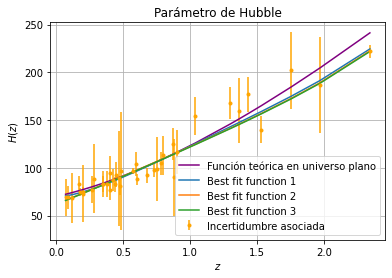

In [3203]:
#Con 58 generaciones 
def prueba1(x):
    return ((x)+1)/0.076440963808876/0.9865507027205893/0.3751230001647017/0.774292136282387/0.774292136282387+(x)**(x)/((x)+1)/0.076440963808876-(((0.3751230001647017)**(0.3751230001647017))+1)*0.9865507027205893/0.8479291582610087/(x)**(x)/(0.3751230001647017)**(0.3751230001647017)/(x)**(x)-0.3751230001647017*(x)**2-0.076440963808876*0.076440963808876*(x)**(x)*(x)**3+((((0.076440963808876)+1))+1)*0.076440963808876+0.8479291582610087*0.774292136282387*0.9865507027205893*(0.3751230001647017)**(0.3751230001647017)*0.8479291582610087+0.8479291582610087/(0.076440963808876)**(0.076440963808876)

def prueba2(x):
    return ((x)+1)/0.11868731032930269/0.11868731032930269*0.9582400836515829+0.9582400836515829-((x)+1)/0.11868731032930269+(x)**(x)*((((0.9582400836515829)+1))+1)/0.9582400836515829-0.9582400836515829+0.44260657174987694*0.44260657174987694/0.9582400836515829*(x)**2-0.4267146820115534*0.4267146820115534*(((((0.11868731032930269)+1))**2)**2)**(((((0.11868731032930269)+1))**2)**2)*0.44260657174987694-(0.11868731032930269)**(0.11868731032930269)*0.11868731032930269*((0.22054907079895358)**(0.22054907079895358))**2*0.22054907079895358*0.9582400836515829/0.11868731032930269
 
def prueba3(x):
    return ((x)+1)/0.11868731032930269/0.11868731032930269*0.9582400836515829+0.9582400836515829-((x)+1)/0.11868731032930269+(x)**(x)*((((0.9582400836515829)+1))+1)/0.9582400836515829-((0.44260657174987694)+1)+(0.11868731032930269)**2/((0.11868731032930269)+1)*0.11868731032930269*(x)**2+0.22054907079895358*0.11868731032930269*0.11868731032930269+0.11868731032930269/0.9582400836515829*(x)**2


yerr = desv
plt.xlabel('$ z $')
plt.ylabel('$ H(z) $')
plt.title('Parámetro de Hubble')


omega_0 = 1
omega_k = 1 - omega_0
plt.plot(array_z, H_t(array_z), color = 'purple', label='Función teórica en universo plano')
#omega_0 = 0.5
#omega_k = 1 -omega_0
#plt.plot(array_z, H_t(array_z), label= 'Ecuación universo abierto')
#omega_0 = 1.5
#omega_k = 1 -omega_0
#plt.plot(array_z, H_t(array_z), label= 'Ecuación universo cerrado')

plt.plot(z, prueba1(z), label= 'Best fit function 1')
plt.plot(z, prueba2(z), label= 'Best fit function 2')
plt.plot(z, prueba3(z), label= 'Best fit function 3')

plt.errorbar(z, H, yerr=yerr, fmt='.', color = 'orange', label = 'Incertidumbre asociada')
plt.legend()
plt.grid(True)
plt.show()